In [1]:
#!/usr/bin/python

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.cm as cm

import seaborn as sns
plt.rcParams.update(plt.rcParamsDefault)

#for simple fitting
import scipy.integrate as spi

%matplotlib inline


In [2]:
#import data
long_df=pd.read_csv('data/long_df.csv')
long_df_wtot=pd.read_csv('data/long_df_wtot.csv')
more_correlates=pd.read_csv('data/more_correlates.csv')

#define some constant names

celltypes=['TN', 'TSCM','TCM', 'TTM','TEM'] #cell type names
states=['T10_mode','T20_mode','T30_mode','T40_mode','T50_mode'] #state names, node mode

cellcolors=['deepskyblue','green','gold','orange','crimson']
cellnames=['$\mathrm{T_N}$','$\mathrm{T_{SCM}}$','$\mathrm{T_{CM}}$','$\mathrm{T_{TTM}}$','$\mathrm{T_{EM}}$']

my_pal=dict(zip(celltypes,cellcolors)) #color dictionary


In [3]:
#pick the best model
#mname='6diff-corrmat'
mname='6diff-corrmat_paramconstrained'


In [4]:
#plot each fit separately relative to trial initiation

#subfraction model 
#copied and pasted from monolix with conversion to X and dY
def model(X,t,th1,th2,th3,th4,th5,phi12,phi13,phi23,phi34,phi35,phi45):

    T1,T2,T3,T4,T5 = X

    ddt_T1 = th1*T1 - phi12*T1 - phi13*T1         
    ddt_T2 = th2*T2 + phi12*T1 - phi23*T2
    ddt_T3 = th3*T3 + phi23*T2 - phi34*T3 - phi35*T3 + phi13*T1 
    ddt_T4 = th4*T4 + phi34*T3 - phi34*T4
    ddt_T5 = th5*T5 + phi45*T4 + phi35*T3

    return np.array([ddt_T1,ddt_T2,ddt_T3,ddt_T4,ddt_T5])


In [5]:
#info for monolix model
param_df=pd.read_csv('../monolix2/'+mname+'/IndividualParameters/estimatedIndividualParameters.txt')

popparamz=pd.read_csv('../monolix2/'+mname+'/populationParameters.txt')


In [6]:
#get list of parameter names
pnames=[]
for cc in list(param_df.columns):
    if '_mode' in cc:
        pnames.append(cc)
for ss in states:
    pnames.remove(ss)
    
pdf = param_df[pnames]
pdf.head()


,th1_mode,th2_mode,th3_mode,th4_mode,th5_mode,phi12_mode,phi13_mode,phi23_mode,phi34_mode,phi35_mode,phi45_mode
0,-0.076998,-1.009010,1.458700,-0.033879,-3.421770,0.064826,0.738636,0.886769,0.714314,0.294866,0.324126
1,0.601640,-0.757764,0.789985,0.215219,-2.842040,0.042181,0.290184,0.868665,0.785369,0.483485,0.348066
2,0.299329,-0.398474,0.941886,-0.066243,-2.231850,0.063292,0.395659,0.847674,0.769776,0.479001,0.384130
3,0.292161,-0.078074,1.002960,0.253544,-2.092130,0.065302,0.401466,0.827413,0.819455,0.500772,0.380874
4,0.320943,1.341970,0.949497,0.501199,-0.526391,0.064237,0.386100,0.742306,0.777655,0.501977,0.405412


In [7]:
#also read in turnover rates 
rate_df = long_df[~np.isnan(long_df['cellular_hl_days'])]
PIDS=rate_df['pat_id'].unique()

turnrate_l=[]
for pind,p in enumerate(PIDS):
    tdf=rate_df[rate_df['pat_id']==p]
    turnrate = np.log(2)/tdf['cellular_hl_days'].unique()*365
    turnrate_l.append(list(turnrate))
aL_df = pd.DataFrame(turnrate_l,columns=celltypes)



/Applications/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


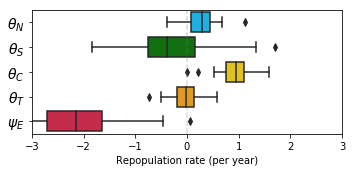

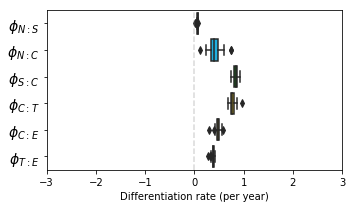

In [8]:
#BOXPLOTS of all rates

#plot clearance rates 
rates=['th1_mode','th2_mode','th3_mode','th4_mode','th5_mode',]
fancy_names=[r'$\theta_N$',r'$\theta_S$',r'$\theta_C$',r'$\theta_T$',r'$\psi_E$']
my_pal_th=dict(zip(rates,cellcolors))

maxx=3

plt.figure(figsize=(5,2.5))
sns.boxplot(data=pdf[rates],width=0.8,palette=my_pal_th,vert=False)
plt.axvline(0,color='gray',ls='--',alpha=0.3)
plt.yticks(range(len(rates)),fancy_names,rotation=0,fontsize=14)
plt.xlabel('Repopulation rate (per year)')
plt.xlim([-maxx,maxx])
plt.tight_layout()
plt.savefig('figures/BM_th2.pdf',dpi=600)

#plot differentiation rates 
rates = ['phi12_mode','phi13_mode','phi23_mode', 'phi34_mode','phi35_mode', 'phi45_mode']
fancy_names=[r'$\phi_{N:S}$',r'$\phi_{N:C}$',r'$\phi_{S:C}$',r'$\phi_{C:T}$',r'$\phi_{C:E}$',r'$\phi_{T:E}$']
my_pal_phi=dict(zip(rates,['deepskyblue','deepskyblue','green','gold','gold','orange']))

plt.figure(figsize=(5,3))
sns.boxplot(data=pdf[rates],width=0.8,palette=my_pal_phi,vert=False)
plt.axvline(0,color='gray',ls='--',alpha=0.3)
plt.yticks(range(len(rates)),fancy_names,rotation=0,fontsize=14)
plt.xlabel('Differentiation rate (per year)')
plt.xlim([-maxx,maxx])
plt.tight_layout()
plt.savefig('figures/BM_phi_box2.pdf',dpi=600)



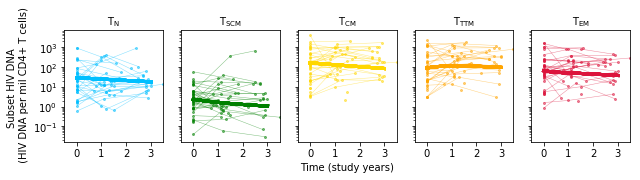

In [9]:
#show population parameter solution

fig,axarr=plt.subplots(1,5,figsize=(9,2.5),sharex=True,sharey=True)

tsim=np.linspace(0,3,100) #simulate over 3 years

#solve model with initial conditions and model parameters from plist df
plist=popparamz.iloc[5:16,:]['value'].values
X0=popparamz.iloc[:5,:]['value'].values
sol=spi.odeint(model, X0, tsim, tuple(plist))

for p in list(long_df['pat_id'].unique()):
    
    tdf=long_df[long_df['pat_id']==p]
    
    for ic,ct in enumerate(celltypes):

        #get observation data and plot
        tdf2=tdf[tdf['celltype']==ct]

        axarr[ic].plot(tdf2['time_postART_years']-np.min(tdf2['time_postART_years']),tdf2['DNApmCD4'],
                       marker='o',alpha=0.5,color=cellcolors[ic],ls='-',lw=0.5,markersize=2)#,label=p)

        #plot simulations
        axarr[ic].semilogy(tsim,sol[:,ic],ls='-',alpha=0.8,lw=3,color=cellcolors[ic])#,label='model')
        axarr[ic].set_title(cellnames[ic],fontsize=10)

    #net slope over 3 years!

nm = (sol[-1,:] - sol[0,:]) / 3 
TOTALSLOPES=nm/365 #put it in days

#net half-life!
r = (np.log(sol[-1,:]) - np.log(sol[0,:])) / 3 
TOTALhls=-np.log(2)/r*12

axarr[0].set_xticks(range(4))
axarr[0].set_xlim([-0.5,3.5])
axarr[2].set_xlabel('Time (study years)')
axarr[0].set_ylabel('Subset HIV DNA \n (HIV DNA per mil CD4+ T cells)')

plt.tight_layout()    

plt.savefig('figures/fits2_pop.pdf',dpi=600)



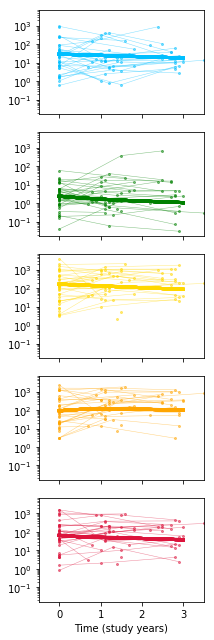

In [22]:
#show population parameter solution

fig,axarr=plt.subplots(5,1,figsize=(3,9),sharex=True,sharey=True)

tsim=np.linspace(0,3,100) #simulate over 3 years

#solve model with initial conditions and model parameters from plist df
plist=popparamz.iloc[5:16,:]['value'].values
X0=popparamz.iloc[:5,:]['value'].values
sol=spi.odeint(model, X0, tsim, tuple(plist))

for p in list(long_df['pat_id'].unique()):
    
    tdf=long_df[long_df['pat_id']==p]
    
    for ic,ct in enumerate(celltypes):

        #get observation data and plot
        tdf2=tdf[tdf['celltype']==ct]

        axarr[ic].plot(tdf2['time_postART_years']-np.min(tdf2['time_postART_years']),tdf2['DNApmCD4'],
                       marker='o',alpha=0.5,color=cellcolors[ic],ls='-',lw=0.5,markersize=2)#,label=p)

        #plot simulations
        axarr[ic].semilogy(tsim,sol[:,ic],ls='-',alpha=0.8,lw=3,color=cellcolors[ic])#,label='model')
        #axarr[ic].set_ylabel(cellnames[ic],fontsize=10)

    #net slope over 3 years!

axarr[0].set_xticks(range(4))
axarr[0].set_xlim([-0.5,3.5])
axarr[4].set_xlabel('Time (study years)')
#axarr[0].set_ylabel('Subset HIV DNA \n (HIV DNA per mil CD4+ T cells)')

plt.tight_layout()    

plt.savefig('figures/fits_constrained_pop2.pdf',dpi=600)



In [10]:
(sol[-1,:]-sol[0,:]) / 3 

array([ -3.68222653,  -0.4358572 , -26.28796863,   2.15712806,
        -9.35682776])

In [11]:
np.sum(sol[-1,:]-sol[0,:]) / 3

-37.60575205288622

In [12]:
start_sizes=np.array(sol[0,:])
final_sizes=np.array(sol[-1,:])

chg_s = (final_sizes-start_sizes)

r = (np.log(final_sizes)-np.log(start_sizes))/3
hl=-np.log(2)/r

pctchg_s = (final_sizes-start_sizes)/ start_sizes * 100

chg_tot = np.sum(final_sizes)-np.sum(start_sizes)
pctchg_tot = (np.sum(final_sizes)-np.sum(start_sizes))/np.sum(start_sizes)*100
print(chg_s)
print(pctchg_s)
print(chg_tot)
print(pctchg_tot)
print(r)
print(hl)

totr = (np.log(np.sum(final_sizes)) - np.log(np.sum(start_sizes))) / 3
tothl = -np.log(2)/totr

print(totr)
print(tothl)


[-11.04667958  -1.30757161 -78.86390588   6.47138418 -28.07048328]
[-38.05056868 -55.13438036 -48.17576202   7.20673441 -42.6522213 ]
-112.81725615865867
-32.16802715824059
[-0.15961725 -0.26716613 -0.21910408  0.02319629 -0.18534536]
[  4.34255802   2.59444256   3.16355218 -29.88180715   3.73976012]
-0.12937884212050754
5.3575002620159955


In [13]:
#solve ODES a bunch of times and calculate fraction from prolif/death/longevity

tsim=np.linspace(0,3,1000) #simulate over whole interval
dt=tsim[1]

prolifs=np.zeros([len(PIDS),5]); deaths=np.zeros([len(PIDS),5]); 
diffs_in=np.zeros([len(PIDS),5]); diffs_out=np.zeros([len(PIDS),5]); neteff=np.zeros([len(PIDS),5])

TOTALSLOPES=[]
TOTALhls=[]

aLl=[]; dLl=[]
for pind,p in enumerate(PIDS):
    
    tdf_p = param_df[param_df['id']==p].iloc[0]

    th=np.array(tdf_p[pnames].iloc[:5])
    phi=np.array(tdf_p[pnames].iloc[5:])
    
    X0=np.array(tdf_p[states]) #don't actually track total here
    sol2=spi.odeint(model, X0, tsim, tuple(list(th)+list(phi)))
    
    #get individual single slopes from the best models for each individual

    #net slope over 3 years!
    nm = (sol2[-1,:] - sol2[0,:]) / 3 
    TOTALSLOPES.append(nm/365) #put it in days
    
    #net half-life!
    r = (np.log(sol2[-1,:]) - np.log(sol2[0,:])) / 3 
    TOTALhls.append(-np.log(2)/r*12)
    
    TNt,TSt,TCt,TTt,TEt = sol2.T

    #impute turnover rate
    turnrates = turnrate_l[pind]   

    #aLN,aLS,aLC,aLT,aLE=turnrates #this would be an overly naive assumption
    
    #instead do a more complicated calculation that accounts for differentiation
    #turnover rate = death + differentiation out
    dLN = turnrates[0] - tdf_p['phi12_mode'] - tdf_p['phi13_mode']
    dLS = turnrates[1] - tdf_p['phi23_mode']
    dLC = turnrates[2] - tdf_p['phi34_mode'] - tdf_p['phi35_mode']
    dLT = turnrates[3] - tdf_p['phi45_mode']
    dLE = turnrates[4]
        
    #now rebalance with net repopulation rate too (because dL with differentiation assumption assumes in = out)
    dL = np.array([dLN,dLS,dLC,dLT,dLE])
    aL=dL+th
        
    #deal with negatives by switching
    dL[aL<0]+=-aL[aL<0]
    aL[dL<0]+=-dL[dL<0]
    aL[aL<0]=0 #make it all prolif or death here
    dL[dL<0]=0

    #reset individual values
    aLN,aLS,aLC,aLT,aLE=np.copy(aL)
    dLN,dLS,dLC,dLT,dLE=np.copy(dL)
    
    aLl.append(aL); dLl.append(dL)
    
    #calculate the number of events in a time interval TT
    # celltype/milCD4 * events/year * 1 year 
    TT=1 #1year
    
    diffs_in[pind,1] = np.mean(tdf_p['phi12_mode']*TNt*TT) #1:2
    diffs_in[pind,2] = np.mean(tdf_p['phi13_mode']*TNt*TT + tdf_p['phi23_mode']*TSt*TT) #1:3 + 2:3
    diffs_in[pind,3] = np.mean(tdf_p['phi34_mode']*TCt*TT) #3:4
    diffs_in[pind,4] = np.mean(tdf_p['phi35_mode']*TCt*TT + tdf_p['phi45_mode']*TTt*TT) #3:5 + 4:5
        
    diffs_out[pind,0] = np.mean(tdf_p['phi12_mode']*TNt*TT + tdf_p['phi13_mode']*TNt*TT) #1:2 & 1:3
    diffs_out[pind,1] = np.mean(tdf_p['phi23_mode']*TSt*TT) #2:3
    diffs_out[pind,2] = np.mean(tdf_p['phi34_mode']*TCt*TT + tdf_p['phi35_mode']*TCt*TT) #1:2 & 1:3
    diffs_out[pind,3] = np.mean(tdf_p['phi45_mode']*TTt*TT)

    prolifs[pind,:]=np.mean([aLN*TNt,aLS*TSt,aLC*TCt,aLT*TTt,aLE*TEt],axis=1)*TT #proliferations averaged over all times
    
    deaths[pind,:]=np.mean([dLN*TNt,dLS*TSt,dLC*TCt,dLT*TTt,dLE*TEt],axis=1)*TT #deaths

    #deal with negative signs
    #deaths[prolifs<0]+=-prolifs[prolifs<0]
    #prolifs[deaths<0]+=-deaths[deaths<0]
    #prolifs[prolifs<0]=0
    #deaths[deaths<0]=0



In [14]:
#name two ways, short and long
mechs=['Diff-in','Prolif','Diff-out','Death']
mechs1=['Differentiation in','Proliferation','Differentiation out','Death']


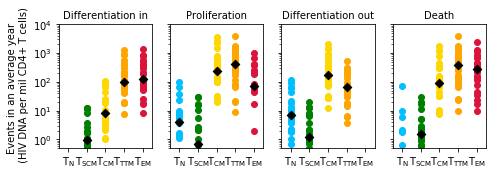

In [15]:
#plot absolute values of events in a year
fig,axarr=plt.subplots(1,4,figsize=(7,2.5),sharex=True,sharey=True)

for ic in range(5):
    for iy,yf in enumerate([diffs_in[:,ic],prolifs[:,ic],diffs_out[:,ic],deaths[:,ic]]):
        axarr[iy].scatter(np.ones(len(yf))*(ic+1),yf,color=cellcolors[ic])
        axarr[iy].scatter((ic+1),np.nanmedian(yf),marker='D',color='k')

axarr[0].set_xlim([0.5,5.5])
axarr[0].semilogy()
axarr[0].set_ylim([0.5,1e4])
axarr[0].set_ylabel('Events in an average year \n (HIV DNA per mil CD4+ T cells)')
axarr[0].set_xticks(np.arange(1,6))
axarr[0].set_xticklabels(cellnames)

for im,m in enumerate(mechs1):
    axarr[im].set_title(m,fontsize=10)

#plt.ylim([-100,100])
plt.tight_layout()
plt.savefig('figures/mech_absolute2.pdf',dpi=600)


In [16]:
#do percentage cacluations
prol_pct = prolifs/(prolifs+diffs_in)*100
dfin_pct = diffs_in/(prolifs+diffs_in)*100
dfout_pct = diffs_out/(diffs_out+deaths)*100
death_pct = deaths/(diffs_out+deaths)*100


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


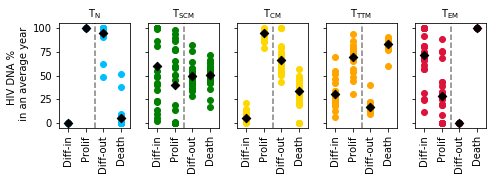

In [17]:
#pct plot split by celltype

fig,axarr=plt.subplots(1,5,figsize=(7,2.6),sharex=True,sharey=True)

for ic in range(5):
    for iy,yf in enumerate([dfin_pct[:,ic],prol_pct[:,ic],dfout_pct[:,ic],death_pct[:,ic]]):
        axarr[ic].scatter(np.ones(len(yf))*(iy+1),yf,color=cellcolors[ic])
        axarr[ic].scatter((iy+1),np.nanmean(yf),marker='D',color='k')
    axarr[ic].set_title(cellnames[ic],fontsize=10)
    axarr[ic].axvline(2.5,ls='--',color='gray')
    axarr[ic].set_xticks(np.arange(1,5))
    axarr[ic].set_xticklabels(mechs,rotation =90)

axarr[0].set_xlim([0.5,4.5])
axarr[0].set_ylim([-5,105])
axarr[0].set_ylabel('HIV DNA % \n in an average year')
plt.tight_layout()
plt.savefig('figures/mech%2.pdf',dpi=600)


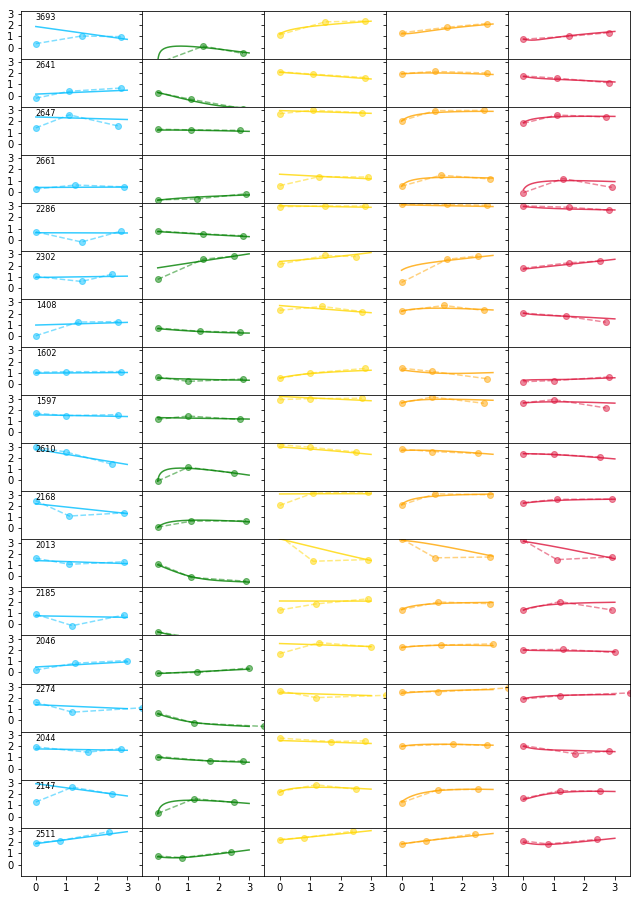

In [18]:
#plot each fit separately relative to trial initiation
#SQUEEZED together into 1 plot
#log scale and fixed y axis, so fits look really good but lots of white space

N=18
fig,axarr=plt.subplots(N,len(celltypes),figsize=(9,N*0.7),sharex=True,sharey=True,)

tsim=np.linspace(0,3,1000) #simulate over 3 years

ip=0
pp=0
while ip<N:
    p=long_df['pat_id'].unique()[pp]
    pp+=1
    tdf=long_df[long_df['pat_id']==p]
    if ~np.isnan(tdf['DNApmCD4']).any(): #only plot 3 time point individuals
                
        #solve model with initial conditions and model parameters from plist df
        plist=np.array(param_df[param_df['id']==p][pnames].iloc[0])
        X0=np.array(param_df[param_df['id']==p][states].iloc[0])
        sol=spi.odeint(model, X0, tsim, tuple(plist))

        for ic,ct in enumerate(celltypes):
            tdf2=tdf[tdf['celltype']==ct]
            axarr[ip][ic].plot(tdf2['time_postART_years']-np.min(tdf2['time_postART_years']),np.log10(tdf2['DNApmCD4']),
                           marker='o',alpha=0.5,color=cellcolors[ic],ls='--')#,label=p)
            axarr[ip][ic].plot(tsim,np.log10(sol[:,ic]),ls='-',alpha=0.8,color=cellcolors[ic])#,label='model')
        
            ddd = tdf2['DNApmCD4']
            
        axarr[ip][0].annotate(str(p),[0,2.5],fontsize=8)
        ip+=1
axarr[0][0].set_yticks([0,1,2,3,4])
axarr[0][0].set_ylim([-1,3.3])
axarr[0][0].set_xticks(range(4))
axarr[0][0].set_xlim([-0.5,3.5])
fig.tight_layout()    
fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('figures/fits_'+mname+'.pdf',dpi=600)



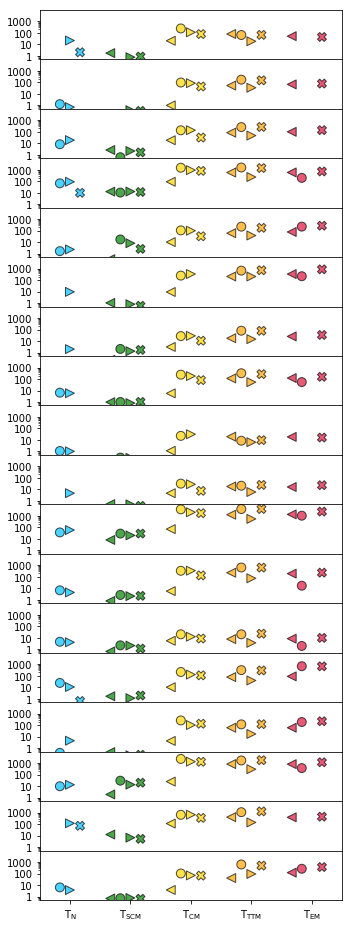

In [19]:
#plot each fit separately relative to trial initiation
#SQUEEZED together into 1 plot

fig,axarr=plt.subplots(N,1,figsize=(5,13),sharex=True,sharey=True,)

tsim=np.linspace(0,3,1000) #simulate over 3 years

ip=0
pp=0
while ip<N:
    p=long_df['pat_id'].unique()[pp]
    pp+=1
    tdf=long_df[long_df['pat_id']==p]
    if ~np.isnan(tdf['DNApmCD4']).any():# and len(tdf)==15: #only plot 3 time opint individuals
                
        axarr[ip].scatter(np.arange(5)-1/3,diffs_in[ip,:],c=cellcolors,marker='<',s=80,edgecolors='k',lw=1,alpha=0.7)
        axarr[ip].scatter(np.arange(5)-1/6,prolifs[ip,:],c=cellcolors,marker='o',s=80,edgecolors='k',lw=1,alpha=0.7)
        axarr[ip].scatter(np.arange(5),diffs_out[ip,:],c=cellcolors,marker='>',s=80,edgecolors='k',lw=1,alpha=0.7)
        axarr[ip].scatter(np.arange(5)+1/6,deaths[ip,:],c=cellcolors,marker='X',s=80,edgecolors='k',lw=1,alpha=0.7)        
        ip+=1
axarr[0].set_xticks(range(5))
axarr[0].set_xlim([-0.5,4.5])
axarr[0].set_xticklabels(cellnames,rotation=0)

axarr[0].semilogy()
axarr[0].set_ylim(0.5,1e4)
axarr[0].set_yticks([1,10,100,1000])
axarr[0].set_yticklabels([1,10,100,1000])
fig.tight_layout()    
fig.subplots_adjust(wspace=0.4, hspace=0)

fig.savefig('figures/indivrates_'+mname+'.pdf',dpi=600)



[  0.           2.69856524  22.08333818 263.63460921 280.39652621]
[ 11.79216447   5.01734367 638.84656127 686.58868405 180.28184551]
[ 21.10502931   3.6768741  424.58706928 119.44406614   0.        ]
[  3.82709353   4.52586039 307.73690566 697.31668663 482.0845936 ]


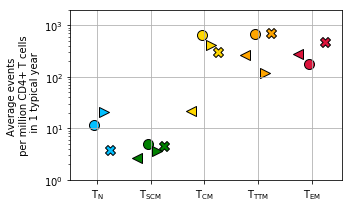

In [20]:
#draw the diagram to scale with rates?
print(np.mean(diffs_in,0))
print(np.mean(prolifs,0))
print(np.mean(diffs_out,0))
print(np.mean(deaths,0))

plt.figure(figsize=(5,3))
#xx=1000
sz=100
for i in range(5):
    plt.scatter(x=i-1/4,s=sz,marker='<',c=cellcolors[i],edgecolors='k',y=np.mean(diffs_in,0)[i])
    plt.scatter(x=i-1/20,s=sz,marker='o',c=cellcolors[i],edgecolors='k',y=np.mean(prolifs,0)[i])
    plt.scatter(x=i+1/8,s=sz,marker='>',c=cellcolors[i],edgecolors='k',y=np.mean(diffs_out,0)[i])
    plt.scatter(x=i+1/4,s=sz,marker='X',c=cellcolors[i],edgecolors='k',y=np.mean(deaths,0)[i])
    
    #plt.plot([i-1/4,i-1/4],[0,np.mean(diffs_in,0)[i]],color=cellcolors[i],ls='-',alpha=0.5)
    #plt.plot([i,i],[0,np.mean(prolifs,0)[i]],color=cellcolors[i],ls='-',alpha=0.5)
    #plt.plot([i+1/8,i+1/8],[0,np.mean(diffs_out,0)[i]],color=cellcolors[i],ls='-',alpha=0.5)
    #plt.plot([i+1/4,i+1/4],[0,np.mean(deaths,0)[i]],color=cellcolors[i],ls='-',alpha=0.5)

plt.grid('on')
plt.ylim([1,2e3])
#plt.yticks([])
plt.xticks(range(5),cellnames)
plt.semilogy()
plt.ylabel('Average events \n per million CD4+ T cells \n  in 1 typical year')
plt.tight_layout()
plt.savefig('figures/indivrates.pdf',dpi=600)



In [21]:
np.mean(diffs_in,0)+np.mean(prolifs,0)-np.mean(diffs_out,0)-np.mean(deaths,0)


array([-13.13995838,  -0.48682559, -71.39407548, 133.46254048,
       -21.40622187])

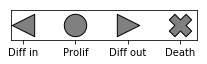

In [22]:
plt.figure(figsize=(3,1))
sz=500
plt.scatter(1,1,marker='<',c='gray',edgecolors='k',s=sz)
plt.scatter(2,1,marker='o',c='gray',edgecolors='k',s=sz)
plt.scatter(3,1,marker='>',c='gray',edgecolors='k',s=sz)
plt.scatter(4,1,marker='X',c='gray',edgecolors='k',s=sz)
plt.xticks([1,2,3,4],['Diff in','Prolif','Diff out','Death'])
plt.ylim([0.9999,1.0001])
plt.yticks([])
plt.tight_layout()
plt.savefig('figures/indivrateskey.pdf',dpi=600)


In [23]:
param_df[['id']+states+pnames].to_excel('BM_params.xls',)

In [24]:
#add clinical/biological info to a new matrix that we'll next merge into rates

more_correlates=pd.read_csv('data/more_correlates.csv')
more_correlates['id']=more_correlates['HOPE ID'] #to make the merge easier

corrdl1 = []

lct_names=''
for ip,p in enumerate(long_df['pat_id'].unique()):
    lct=[]
    lct_names=[]
    for ic,ct in enumerate(celltypes):
    
        tdf=long_df[(long_df['pat_id']==p) & (long_df['celltype']==ct)]
    
        tpre, TRECs, Gini, Age, chl, tpost, IL7, IL15 = tdf[['preART_months','TRECs','GiniInd',
                                                             'Age_years','cellular_hl_days','time_postART_years',
                                                             'IL7','IL15']].iloc[0].values

        lct.append(chl)
        lct.append(Gini)
        lct_names.append(ct+'_hl')
        lct_names.append(ct+'_G')
    
    #tdf2=long_df_wtot[(long_df_wtot['celltype']=='total') & (long_df_wtot['pat_id']==p)]
    corrdl1.append([p,tpre,tpost, TRECs,Age,IL7,IL15]+lct)
        
corr1 = pd.DataFrame(corrdl1,columns=['id','preARTmo','postARTyr','TRECs','Age','IL7','IL15']+lct_names)

#update all correlates
more_correlates = pd.merge(more_correlates,corr1)

#merge to make the correlation between params and clinical vars
clincorr_df = pd.merge(more_correlates,param_df[pnames+['id']])

clincorr_df['CD4delta']=clincorr_df['CD4 T cell count Y1']-clincorr_df['CD4 Nadir']
clincorr_df.columns

#make the full correlation matrix
corr_mat = clincorr_df.corr(method='spearman').round(decimals=2)


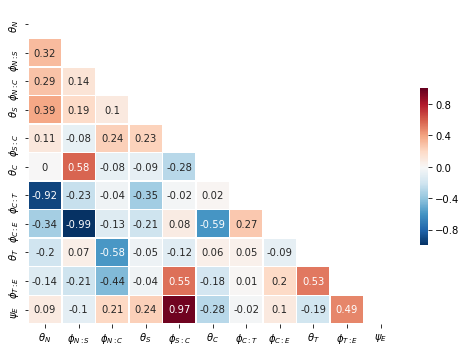

In [25]:
#check identifiability!

fancy_names=[r'$\theta_N$',r'$\phi_{N:S}$',r'$\phi_{N:C}$',
             r'$\theta_S$',r'$\phi_{S:C}$',
             r'$\theta_C$',r'$\phi_{C:T}$',r'$\phi_{C:E}$',
             r'$\theta_T$',r'$\phi_{T:E}$',r'$\psi_E$']

rowz=pnames
colz=pnames
tcmat=corr_mat.loc[rowz,colz] #temporary subset

maskz = np.triu(np.ones_like(tcmat, dtype=bool)) # Generate a mask for the upper triangle

plt.figure(figsize=(7,5))
sns.heatmap(tcmat,annot=True,vmin=-1,vmax=1,
            xticklabels=fancy_names,yticklabels=fancy_names,
            linewidths=.5, cbar_kws={"shrink": .5}, mask=maskz)
plt.tight_layout()
plt.savefig('figures/correlates_identifiability.pdf',dpi=600)


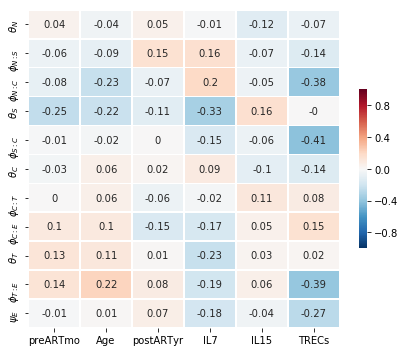

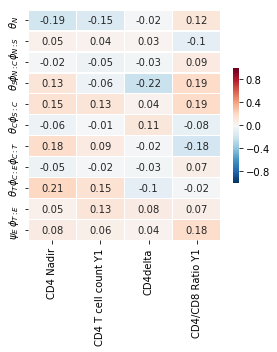

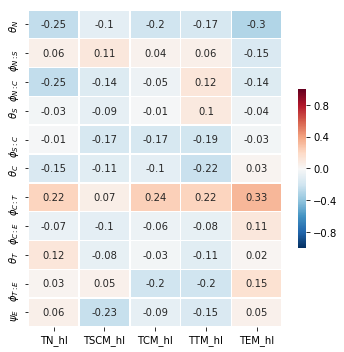

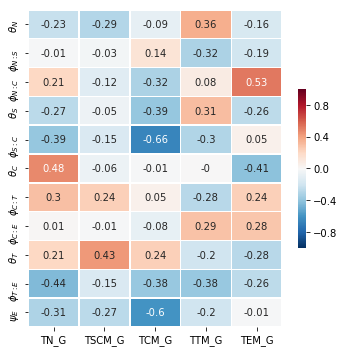

In [26]:
rowz=pnames
colz1=['preARTmo', 'Age', 'postARTyr','IL7','IL15','TRECs']
colz2=['CD4 Nadir', 'CD4 T cell count Y1', 'CD4delta', 'CD4/CD8 Ratio Y1']
colz3=['TN_hl','TSCM_hl','TCM_hl','TTM_hl','TEM_hl']
colz4=['TN_G','TSCM_G','TCM_G','TTM_G','TEM_G']

for ii,colz in enumerate([colz1,colz2,colz3,colz4]):
    tcmat=corr_mat.loc[rowz,colz] #temporary subset
    plt.figure(figsize=(len(colz),5))
    sns.heatmap(tcmat,annot=True,vmin=-1,vmax=1,
                yticklabels=fancy_names,#yticklabels=fancy_names,
                linewidths=.5, cbar_kws={"shrink": .5})
    plt.tight_layout()
    plt.savefig('figures/correlates'+str(ii)+'.pdf',dpi=600)


In [35]:
### KNOCKOUTS

#function that simulates and plots for knockouts
def sim_knockouts(fn,eps_aL_vec,eps_phi_vec):
    tsim=np.linspace(0,3,1000) #simulate over whole interval
    dt=tsim[1]

    start_sizes=[]
    final_sizes=[]

    NN=len(PIDS)

    fig,axarr=plt.subplots(1,5,figsize=(7,2),sharex=True,sharey=True)
    for pind,p in enumerate(PIDS[:NN]):

        tdf_p = param_df[param_df['id']==p]

        th=np.array(tdf_p[pnames].iloc[0,:5])
        phi=np.array(tdf_p[pnames].iloc[0,5:])

        turnrates = turnrate_l[pind]   
        
        #use the list from calculation way above for mechanistic components
        aL = np.array(aLl[pind])
        dL = np.array(dLl[pind])
        
        #recalc with therapy
        th=aL/eps_aL_vec-dL
        phi=phi*eps_phi_vec

        X0=np.array(tdf_p[states].iloc[0]) #don't actually track total here

        sol=spi.odeint(model, X0, tsim, tuple(list(th)+list(phi)))

        ct_starts=[]; ct_finals=[]
        for ic,ct in enumerate(celltypes):
            axarr[ic].semilogy(tsim,sol[:,ic],ls='-',alpha=0.5,color=cellcolors[ic])#cz_list[pind])
            ct_starts.append(sol[ 0,ic])
            ct_finals.append(sol[-1,ic])

        start_sizes.append(ct_starts)
        final_sizes.append(ct_finals)

    #switch to array
    start_sizes=np.array(start_sizes)
    final_sizes=np.array(final_sizes)

    #axarr[2].set_xlabel('Time (study years)')
    #axarr[0].set_ylabel('Modeled HIV DNA \n per mil CD4+ T cell')
    axarr[0].set_ylim([1,1e4])

    for ic,ct in enumerate(celltypes):
        #axarr[ic].set_title(cellnames[ic])
        axarr[ic].boxplot([start_sizes[:,ic],final_sizes[:,ic]],positions=[0,3])#cz_list[pind])
        #axarr[ic].boxplot(final_sizes[:,ic],positions=[3])#cz_list[pind])
        p=st.mannwhitneyu(start_sizes[:,ic],final_sizes[:,ic])[1]
        #if p<0.01:
        #    axarr[ic].annotate('p<0.01',[0.1,3e3])
        #else:
        #    axarr[ic].annotate('p='+str(np.round(p,3)),[0.1,3e3])

    for ic,ct in enumerate(celltypes):
        axarr[ic].set_xticks(range(5))
        axarr[ic].set_xticklabels(range(5))
        axarr[ic].set_xlim([-0.3,3.3])
        
    chg_s = np.median((final_sizes-start_sizes),axis=0)
    chg_rng = [list(np.round(np.min((final_sizes-start_sizes),axis=0))),list(np.round(np.max((final_sizes-start_sizes),axis=0)))]

    pctchg_s = np.median((final_sizes-start_sizes)/ start_sizes * 100,axis=0)
        
    chg_tot = np.sum(chg_s) #np.sum(final_sizes)-np.sum(start_sizes)
    pctchg_tot = np.sum(pctchg_s) #(np.sum(final_sizes)-np.sum(start_sizes))/np.sum(start_sizes)*100
    
    plt.tight_layout()
    plt.savefig('figures/'+fn+'.pdf',dpi=600)

    print(np.round(chg_s),chg_rng)
    #print(pctchg_s)
    #print(chg_tot)
    #print(pctchg_tot)
    


[ -8.  -1. -50.  59.   4.] [[-564.0, -36.0, -2185.0, -1582.0, -1303.0], [61.0, 21.0, 214.0, 1003.0, 298.0]]
[ -12.   -1. -138.  -73.  -60.] [[-564.0, -44.0, -2204.0, -1634.0, -1332.0], [1.0, 3.0, 5.0, 2.0, 1.0]]
[ -14.   -1. -144.  -71.  -27.] [[-586.0, -45.0, -2210.0, -1640.0, -1328.0], [4.0, 5.0, 6.0, 13.0, 245.0]]
[ -14.   -1. -140.  -70.  -41.] [[-580.0, -44.0, -2208.0, -1637.0, -1329.0], [5.0, 5.0, 11.0, 11.0, 10.0]]


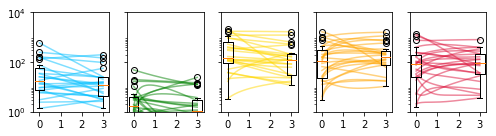

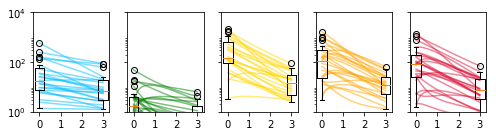

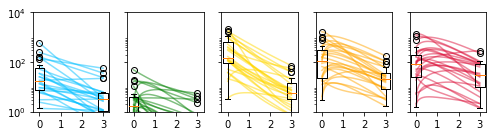

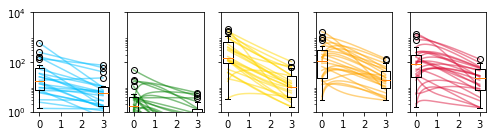

In [36]:
#solve ODES a bunch of times and calculate fraction from prolif/death/longevity

sim_knockouts('sim_control',np.ones(5),np.ones(6)) #control sim

sim_knockouts('sim_antiprolif_all_2x',np.ones(5)*2,np.ones(6))

sim_knockouts('sim_prodiff_all_2x',np.ones(5),np.ones(6)*2)

sim_knockouts('sim_combo_all_1o5x',np.ones(5)*1.25,np.ones(6)*1.5)



In [29]:
#get the absolute and fold change to compare with sims later
ip=0
pp=0
start_sizes=[]
final_sizes=[]
while ip<N:
    p=long_df['pat_id'].unique()[pp]
    pp+=1
    tdf=long_df[long_df['pat_id']==p]
    if ~np.isnan(tdf['DNApmCD4']).any(): #only plot 3 time point individuals
        ct_starts=[]; ct_finals=[]
        for ic,ct in enumerate(celltypes):
            tdf2=tdf[tdf['celltype']==ct]        
            ddd = tdf2['DNApmCD4']

            ct_starts.append(ddd.iloc[0])
            ct_finals.append(ddd.iloc[-1])

        start_sizes.append(ct_starts)
        final_sizes.append(ct_finals)

        ip+=1

#switch to array
start_sizes=np.array(start_sizes)
final_sizes=np.array(final_sizes)

chg_s = np.median((final_sizes-start_sizes),axis=0)

pctchg_s = np.median((final_sizes-start_sizes)/ start_sizes * 100,axis=0)

chg_tot = np.sum(final_sizes)-np.sum(start_sizes)
pctchg_tot = (np.sum(final_sizes)-np.sum(start_sizes))/np.sum(start_sizes)*100
print(chg_s)
print(pctchg_s)
print(chg_tot)
print(pctchg_tot)



[  1.335  -0.35  111.94   34.92    0.71 ]
[ 32.55076491 -12.45844058  46.0130299   97.50432873  17.66458909]
-2038.9400000000023
-9.350606706678118
